# IBM HR Analytics Employee Attrition & Performance 

- 목표: 직원 이직 여부를 예측하는 모델을 구축하고, 직원의 이직 원인과 관련된 인사이트를 도출
- 예상 결과: 향후 예측 모델을 통해 이직할 가능성이 있는 직원을 예측하고 조직의 인사 전략을 대응 및 개선 방향
- 아키텍처 정의: 데이터 수집, 데이터 저장 및 처리, 데이터분석 및 모델링, 결과 시각화 및 대시보드
- 개발 및 환경 구축: 
     - PySpark 의한 데이터 처리,Python 데이터 분석 및 머신모델을 위한 언어
     - Jupyter Notebook 코드 실행 및 결과 확인을 위한 인터페이스
     - AWS EC2 클라우드 환경 사용
     - GitHub: 코드 백업
- 계발 계획: 
    1. 데이터수집
    2. 데이터 전처리
    3. 탐색적 데이터 분석 (EDA)
    4. 머신러닝 모델링
    5. 모델 평가
    6. 시각화 및 대시보드
- 테스트 계획: 훈련 데이터와 테스트 데이터를 나누어 모델 성능 테스트 
- 데이터 출처: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/data


# 1. 데이터수집

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Employee_Attrition").getOrCreate()
spark

24/12/18 15:13:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
df = spark.read.format("csv")\
    .option("header",'true')\
    .option('inferSchema', 'true')\
    .load("data/HR-Employee-Attrition.csv")

In [11]:
#필요한 라이브러리 불러오기 

from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark.ml.recommendation import *
from pyspark.ml.evaluation import *
from pyspark.ml.classification import *
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 데이터 구조 확인

In [4]:
df.count()

1470

In [5]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string 

## 컬럼 설명

- Age: 직원의 나이
- Attrition: 직원의 이직 여부 (Yes or No)
- BusinessTravel: 직원의 출장 빈도 (Non-Travel, Travel_Rarely, Travel_Frequently)
- DailyRate: 직원의 일일 급여
- Department: 직원이 속한 부서 (Research & Development, Sales, Human Resources)
- DistanceFromHome: 직원의 집으로부터 회사까지의 거리
- Education: 직원의 학력 수준 (1: Below College, 2: College, 3: Bachelor, 4: Master, 5: Doctor)
- EducationField: 직원의 전공 분야
- EmployeeCount: 직원 수 (모든 값이 1로 동일)
- EmployeeNumber: 직원의 고유 번호
- EnvironmentSatisfaction: 직원의 업무 환경 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- Gender: 직원의 성별 (Male, Female)
- HourlyRate: 직원의 시간당 급여
- JobInvolvement: 직원의 직무 참여도 (1: Low, 2: Medium, 3: High, 4: Very High)
- JobLevel: 직원의 직급
- JobRole: 직원의 직무
- JobSatisfaction: 직원의 직무 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- MaritalStatus: 직원의 결혼 여부 (Single, Married, Divorced)
- MonthlyIncome: 직원의 월급
- MonthlyRate: 직원의 월별 급여 총액
- NumCompaniesWorked: 직원이 근무한 회사 수
- Over18: 직원이 18세 이상인지 여부 (모든 값이 Y로 동일)
- OverTime: 직원의 초과 근무 여부 (Yes, No)
- PercentSalaryHike: 직원의 급여 인상 비율
- PerformanceRating: 직원의 성과 평가 등급 (1: Low, 2: Good, 3: Excellent, 4: Outstanding)
- RelationshipSatisfaction: 직원의 동료와의 관계 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- StandardHours: 직원의 표준 근무 시간 (모든 값이 80으로 동일)
- StockOptionLevel: 직원의 주식 옵션 수준 (0, 1, 2, 3)
- TotalWorkingYears: 직원의 총 근무 연수
- TrainingTimesLastYear: 지난해 직원이 받은 교육 횟수
- WorkLifeBalance: 직원의 일-생활 균형 만족도 (1: Bad, 2: Good, 3: Better, 4: Best)
- YearsAtCompany: 직원이 현재 회사에서 근무한 기간
- YearsInCurrentRole: 직원이 현재 역할에서 근무한 기간
- YearsSinceLastPromotion: 직원의 마지막 승진 이후 경과된 기간
- YearsWithCurrManager: 직원이 현재 관리자와 함께 일한 기간

In [6]:
df.show(5)

24/12/18 15:13:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalanc

In [7]:
# 통계 정보 확인
df.describe().show()

+-------+------------------+---------+--------------+------------------+---------------+----------------+------------------+----------------+-------------+-----------------+-----------------------+------+------------------+------------------+------------------+--------------------+------------------+-------------+-----------------+------------------+------------------+------+--------+------------------+-------------------+------------------------+-------------+------------------+------------------+---------------------+------------------+------------------+------------------+-----------------------+--------------------+
|summary|               Age|Attrition|BusinessTravel|         DailyRate|     Department|DistanceFromHome|         Education|  EducationField|EmployeeCount|   EmployeeNumber|EnvironmentSatisfaction|Gender|        HourlyRate|    JobInvolvement|          JobLevel|             JobRole|   JobSatisfaction|MaritalStatus|    MonthlyIncome|       MonthlyRate|NumCompaniesWorked|O

In [8]:
#numeric_cols (Integer) - for 문으로 변경 
numeric_cols = [
    "Age", "DailyRate", "DistanceFromHome", "Education", "EnvironmentSatisfaction",
    "HourlyRate", "JobInvolvement", "JobLevel", "JobSatisfaction", "MonthlyIncome",
    "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "PerformanceRating",
    "RelationshipSatisfaction", "StockOptionLevel", "EmployeeNumber", 
    "EmployeeCount", "StandardHours"
]

for col in numeric_cols:
    df.groupBy(col).count().show()

+---+-----+
|Age|count|
+---+-----+
| 31|   69|
| 53|   19|
| 34|   77|
| 28|   48|
| 27|   48|
| 26|   39|
| 44|   33|
| 22|   16|
| 47|   24|
| 52|   18|
| 40|   57|
| 20|   11|
| 57|    4|
| 54|   18|
| 48|   19|
| 19|    9|
| 41|   40|
| 43|   32|
| 37|   50|
| 35|   78|
+---+-----+
only showing top 20 rows

+---------+-----+
|DailyRate|count|
+---------+-----+
|      833|    2|
|      496|    1|
|      471|    3|
|     1342|    1|
|      148|    1|
|     1238|    1|
|     1127|    1|
|     1395|    3|
|     1084|    2|
|      243|    1|
|      737|    1|
|      392|    1|
|      897|    1|
|     1339|    2|
|     1303|    2|
|     1322|    2|
|      516|    1|
|      580|    2|
|     1265|    1|
|      251|    1|
+---------+-----+
only showing top 20 rows



+----------------+-----+
|DistanceFromHome|count|
+----------------+-----+
|              28|   23|
|              27|   12|
|              26|   25|
|              12|   20|
|              22|   19|
|               1|  208|
|              13|   19|
|              16|   32|
|               6|   59|
|               3|   84|
|              20|   25|
|               5|   65|
|              19|   22|
|              15|   26|
|               9|   85|
|              17|   20|
|               4|   64|
|               8|   80|
|              23|   27|
|               7|   84|
+----------------+-----+
only showing top 20 rows

+---------+-----+
|Education|count|
+---------+-----+
|        1|  170|
|        3|  572|
|        5|   48|
|        4|  398|
|        2|  282|
+---------+-----+

+-----------------------+-----+
|EnvironmentSatisfaction|count|
+-----------------------+-----+
|                      1|  284|
|                      3|  453|
|                      4|  446|
|                  

In [9]:
# String 인 데이터 보기
string_cols = [
    "Attrition", "BusinessTravel", "EducationField", "Gender", 
    "JobRole", "MaritalStatus", "Over18", "OverTime"
]
for col in string_cols:
    df.groupBy(col).count().show()

+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+

+-----------------+-----+
|   BusinessTravel|count|
+-----------------+-----+
|Travel_Frequently|  277|
|       Non-Travel|  150|
|    Travel_Rarely| 1043|
+-----------------+-----+

+----------------+-----+
|  EducationField|count|
+----------------+-----+
|Technical Degree|  132|
|           Other|   82|
|       Marketing|  159|
|         Medical|  464|
|   Life Sciences|  606|
| Human Resources|   27|
+----------------+-----+

+------+-----+
|Gender|count|
+------+-----+
|Female|  588|
|  Male|  882|
+------+-----+

+--------------------+-----+
|             JobRole|count|
+--------------------+-----+
|     Sales Executive|  326|
|Manufacturing Dir...|  145|
|Laboratory Techni...|  259|
|Sales Representative|   83|
|Healthcare Repres...|  131|
|  Research Scientist|  292|
|             Manager|  102|
|   Research Director|   80|
|     Human Resources|   52|
+-----------------

# 2. 데이터 전처리

In [12]:
#각 컬럼별 null 값 개수 확인

null_counts = df.select(
    [
    sum(when(col(c).isNull() | isnan(c),1).otherwise(0)).alias(c) for c in df.columns
    ]
)

null_counts.show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPr

In [13]:
# 중복 데이터 확인 (중복 행의 개수 확인)
df.groupBy(df.columns).count().filter(col("count") > 1).show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+-----+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSince

In [14]:
# 불필요한 컬럼 제거 (하나의 값만 존재)
# EmployeeNumber, EmployeeCount, Over18, StandardHours
df = df.drop("EmployeeNumber","EmployeeCount", "Over18", "StandardHours")
df.show(5)

+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+--------+-----------------+-----------------+------------------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|
+---+---------+---

In [15]:
# 이상치 확인

# 3. 탐색적 데이터 분석 (EDA)

In [16]:
age_attrition = df.groupby("Age", "Attrition").count()
age_attrition.orderBy("Age").show()

+---+---------+-----+
|Age|Attrition|count|
+---+---------+-----+
| 18|       No|    4|
| 18|      Yes|    4|
| 19|       No|    3|
| 19|      Yes|    6|
| 20|       No|    5|
| 20|      Yes|    6|
| 21|      Yes|    6|
| 21|       No|    7|
| 22|      Yes|    5|
| 22|       No|   11|
| 23|      Yes|    4|
| 23|       No|   10|
| 24|       No|   19|
| 24|      Yes|    7|
| 25|      Yes|    6|
| 25|       No|   20|
| 26|      Yes|   12|
| 26|       No|   27|
| 27|       No|   45|
| 27|      Yes|    3|
+---+---------+-----+
only showing top 20 rows



In [17]:
# 수치형 변수 통계 요약 확인
df.describe(["Age", "DailyRate","DistanceFromHome", "MonthlyIncome"]).show()

+-------+------------------+------------------+----------------+-----------------+
|summary|               Age|         DailyRate|DistanceFromHome|    MonthlyIncome|
+-------+------------------+------------------+----------------+-----------------+
|  count|              1470|              1470|            1470|             1470|
|   mean|36.923809523809524| 802.4857142857143|9.19251700680272|6502.931292517007|
| stddev| 9.135373489136729|403.50909994352804|8.10686443566608|4707.956783097992|
|    min|                18|               102|               1|             1009|
|    max|                60|              1499|              29|            19999|
+-------+------------------+------------------+----------------+-----------------+



In [18]:
# 수치형 변수에 대한 히스토그램을 통해 분포 확인 (단, PySpark는 matplotlib을 사용하여 시각화를 하기에 pandas로 변환 후 시각화 가능)
pandas_df = df.select('Age', 'DailyRate', 'DistanceFromHome', 'MonthlyIncome').toPandas()

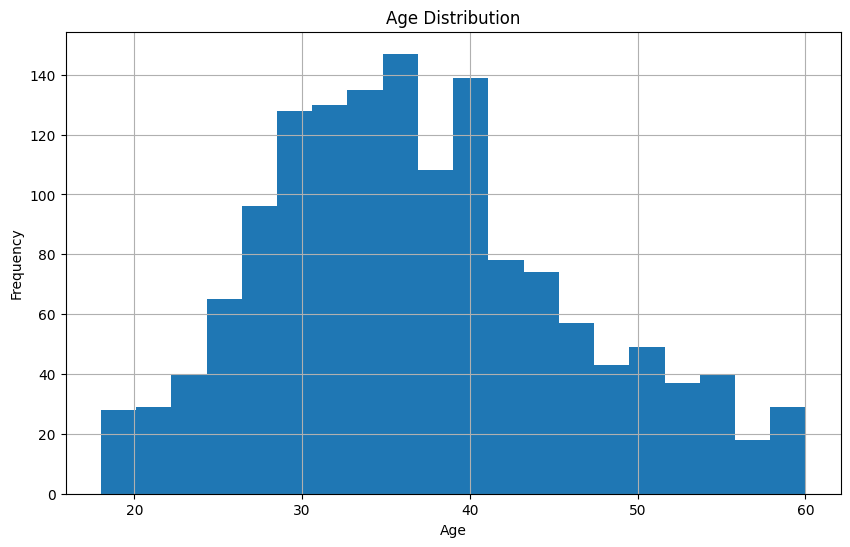

In [19]:
import matplotlib.pyplot as plt

# Age 분포 히스토그램
plt.figure(figsize=(10, 6))
pandas_df['Age'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# 상관관계 분석 (Numeric 컬럼에 대해)
numeric_cols = ["Age", "DailyRate", "DistanceFromHome", "HourlyRate", "MonthlyIncome"]
corr_matrix = df.select(numeric_cols).corr()
corr_matrix.show()

In [20]:
# 이직여부와 다른 변수 관계분석
df.groupBy("Age","Attrition").count().show()
df.groupBy("Department","Attrition").count().show()
df.groupBy("EnvironmentSatisfaction","Attrition").count().show()
df.groupBy("Gender","Attrition").count().show()

+---+---------+-----+
|Age|Attrition|count|
+---+---------+-----+
| 46|      Yes|    4|
| 27|       No|   45|
| 60|       No|    5|
| 33|       No|   46|
| 46|       No|   29|
| 47|       No|   21|
| 52|      Yes|    3|
| 41|       No|   34|
| 39|      Yes|    6|
| 19|      Yes|    6|
| 31|       No|   51|
| 21|       No|    7|
| 31|      Yes|   18|
| 18|       No|    4|
| 40|       No|   52|
| 43|      Yes|    2|
| 36|       No|   63|
| 29|      Yes|   18|
| 51|      Yes|    2|
| 21|      Yes|    6|
+---+---------+-----+
only showing top 20 rows

+--------------------+---------+-----+
|          Department|Attrition|count|
+--------------------+---------+-----+
|Research & Develo...|       No|  828|
|     Human Resources|       No|   51|
|               Sales|      Yes|   92|
|               Sales|       No|  354|
|Research & Develo...|      Yes|  133|
|     Human Resources|      Yes|   12|
+--------------------+---------+-----+

+-----------------------+---------+-----+
|EnvironmentS

# 시각화

# Feature selection

# 머신러닝 모델 생성 및 예측

In [24]:
numeric_cols = [
    "Age", "DailyRate", "DistanceFromHome", "Education", "EnvironmentSatisfaction",
    "HourlyRate", "JobInvolvement", "JobLevel", "JobSatisfaction", "MonthlyIncome",
    "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "PerformanceRating",
    "RelationshipSatisfaction", "StockOptionLevel"
]

In [22]:
# 범주형 데이터 인코딩 - Attrition 0.0 = "No", 1.0 = "Yes"
indexer = StringIndexer(inputCol="Attrition", outputCol="Attrition_Index") 
df = indexer.fit(df).transform(df)

In [25]:
# 특성과 레이블 정의

#numeric_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome']
assembler = VectorAssembler(inputCols=numeric_cols, outputCol='features')
df = assembler.transform(df)

In [26]:
# 로지스틱 회귀 모델
lr = LogisticRegression(featuresCol='features', labelCol='Attrition_Index')

In [27]:
# 훈련 데이터와 테스트 데이터 분리
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

In [28]:
# 모델 훈련
model = lr.fit(train_data)

24/12/18 15:16:09 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/18 15:16:09 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [29]:
# 예측 수행
predictions = model.transform(test_data)

In [30]:
# 예측 성능 평가
evaluator = BinaryClassificationEvaluator(labelCol='Attrition_Index')
auc = evaluator.evaluate(predictions)
auc # 결과값 = 0.6718963831867062 - 기본 예측보다는 나은 성능이지만 개선의 여지가 많음 - 아직 최적화디지 않음

0.7301564027370495

In [31]:
predictions.select('Attrition','Attrition_Index', 'prediction', 'probability').show(truncate=False)

+---------+---------------+----------+----------------------------------------+
|Attrition|Attrition_Index|prediction|probability                             |
+---------+---------------+----------+----------------------------------------+
|No       |0.0            |0.0       |[0.6891300062903215,0.3108699937096785] |
|Yes      |1.0            |0.0       |[0.6955506021043387,0.3044493978956613] |
|No       |0.0            |0.0       |[0.7222602454071366,0.2777397545928634] |
|No       |0.0            |0.0       |[0.6452153909680143,0.3547846090319857] |
|Yes      |1.0            |0.0       |[0.6415738213714391,0.35842617862856085]|
|Yes      |1.0            |0.0       |[0.5156342011348694,0.48436579886513065]|
|Yes      |1.0            |1.0       |[0.49674144548994287,0.5032585545100572]|
|No       |0.0            |1.0       |[0.45055177586786616,0.5494482241321339]|
|No       |0.0            |0.0       |[0.7394704442743075,0.2605295557256925] |
|Yes      |1.0            |0.0       |[0

- Attrition, Attrition_Index: 실제 레이블 (No 0, Yes 1)
- prediction: 모델의 예츨 결과 (No 0, Yes 1)
- probability: 예측 확률 - 첫번째 No 일 확률, 두번째 Yes 일 확률